# Chemical Time Scales
This Jupyter Notebook was written by Dan Haworth. It is intended as a tutorial to be used in parallel with Chapter 4 of the book "An Introduction to Combustion: Concepts and Applications" by Stephen R. Turns and Daniel C. Haworth. That book is referred to as "Turns 4th ed." throughout this Notebook.

This Notebook was last updated 11 February 2020.

The objective of this tutorial is to show how one can compute chemical time scales using Cantera, and to discuss how chemical time scales vary from one reaction to another, and with time over the course of a combustion event. Here a constant-pressure reactor is considered. We will use the thermodynamic properties and the reaction mechanism that are included in gri30.cti.

The reader should be familiar with the material in the previous Notebook (4_3_Constant_volume_reactor) before working through this Notebook.

## 1. Motivation and definitions

As we have seen, the GRI-Mech 3.0 reaction mechanism that describes the combustion of natural gas (mostly methane) with air to produce products of combustion, including the formation of NOx, includes 325 individual reactions involving 53 different species or molecules. Modern reaction mechanisms for larger fuel molecules can include hundreds-to-thousands of individual reactions involving hundreds-to-thousands of species. The reaction rates for the individual reactions typically vary over many orders of magnitude. It is useful to define a time scale for each reaction, which can be used to compare the relative rates of different reactions (e.g., to quantify what we mean when we say that a reaction is "fast" versus "slow"), and to compare chemical reaction time scales to time scales associated with other physical processes, such as molecular or turbulent transport.

Chemical time scales can be defined in various ways. Here we follow the definition introduced in Chapter 4 of Turns 4th ed. There, motivated by the (usually) exponential dependence of reaction rates on temperature, a time scale is defined for each species that participates in a reaction as the time that it would take for the molar concentration of that species to change by a factor of $e$ (where $e$ denotes the basis for natural logarithms - a factor of approximately 2.7) with respect to its initial value by the single reaction under consideration, in the absence of all other reactions. 

For a single bimolecular reaction of the form $ A + B \rightarrow C + D $ (where $A$, $B$, $C$, and $D$ denote four different species or molecules), the corresponding chemical time scale $ \tau _ {chem} $ is given by Eq. (4.74):

$$ \tau _ {chem} = \frac{\ln \{ e + ( 1 - e ) [ A]_0 / [B]_0 \}}{( [B]_0 - [A]_0 ) k (T) } $$

where $ [A]_0 $ and $ [B]_0 $ are the initial molar concentrations of species $A$ and $B$, respectively, and $k(T)$ is the rate constant for the reaction. This expression was derived formally as the time scale associated with species $A$, where $A$ is the species having the lower initial molar concentration on the left-hand side $([A]_0 < [B]_0)$. (Otherwise, there is a risk of attempting to take the logarithm of a negative number.) Recalling that the units of $k(T)$ for a bimolecular reaction are (kmol/m^3)^(-1)/s, it can be seen that this expression is consistent with $ \tau _ {chem} $ having units of time (s).  

For a three-body reaction of the form $ A + B + M \rightarrow C + M $ (where $M$ denotes a generic third body, as discussed in earlier tutorial Notebooks), the corresponding chemical time scale $ \tau _ {chem} $ is given by Eq. (4.77):

$$ \tau _ {chem} = \frac{\ln \{ e + ( 1 - e ) [ A]_0 / [B]_0 \}}{( [B]_0 - [A]_0 ) k (T) [M] } $$

where the same notation has been used. Again, this is a time scale that is associated with the species having the lower initial molar concentration of $A$ or $B$ $([A]_0 < [B]_0)$. Recalling that the units of $k(T)$ for a three-body reaction are (kmol/m^3)^(-2)/s, it can be seen that this expression is consistent with $ \tau _ {chem} $ having units of time (s). 

From these expressions, it can be seen that the chemical time scale depends on the temperature (through $k(T)$) and on the molar concentrations of the reactants. Thus even for a single species in a single reaction, the chemical time scale defined in this manner can vary widely over the course of a combustion event (i.e., through the conversion from fuel+air reactants to products of combustion, with a corresponding rise in temperature). 

The above expressions can be simplified in the case where the initial molar concentration of one reactant is much greater than that of the other $([B]_0 \gg [A]_0)$, as shown in Chapter 4.

## 2. Variation of chemical time scales through a combustion event

Here we explore chemical time scales for the reactions considered in Example 4.5 of Turns 4th ed. (reactions r1-r4 here), plus two other reactions. The reactions considered, and their corresponding reaction indices in gri30.cti, are as follows:

$$ {\rm r1:} \ \ CH_4 + OH \rightarrow CH_3 + H_2O \ \ {(\rm forward \ of \ reaction \ \#97)} $$

$$ {\rm r2:} \ \ CO + OH \rightarrow CO_2 + H \ \ {(\rm forward \ of \ reaction \ \#98)} $$

$$ {\rm r3:} \ \ CH + N_2 \rightarrow HCN + N \ \ {(\rm forward \ of \ reaction \ \#239)} $$

$$ {\rm r4:} \ \ H + OH + M \rightarrow H_2O + M \ \ {(\rm forward \ of \ reaction \ \#42)} $$

$$ {\rm r5:} \ \ N_2 + O \rightarrow NO + N \ \ {(\rm reverse \ of \ reaction \ \#177)} $$

$$ {\rm r6:} \ \ H_2 + OH \rightarrow H_2O + H \ \ {(\rm forward \ of \ reaction \ \#83)} $$

The first reaction is an important step in the oxidation of methane, the second is the key step in CO oxidation, the third is a rate-limiting step in the prompt-NO mechanism, the fourth is a typical radical recombination reaction, the fifth is a key step in thermal NO formation, and the sixth is one direction of a radical "shuffle" reaction. The roles of these reactions will be discussed further in Chapters 4 and 5 of Turns 4th ed.

The chemical time scales will be computed at different instants in a constant-pressure adiabatic combustion process. For that purpose, we use a reactor network as in the previous tutorial Notebook (4_3_Constant_volume_reactor), but now for a constant-pressure process rather than a constant-volume process. 

In subsection 2.1, it is shown how to search the reaction mechanism to find these individual reactions. In subsection 2.2, functions are defined to compute the chemical time scales defined in Section 1 above. In subsection 2.3, time-scale results for reactions r1-r4 are compared with those in Example 4.5. In subsection 2.4, the time evolution of the time scales for these six reactions is computed for a constant-pressure adiabatic combustion system. And in subsection 2.5, the time variation of chemical time scales is discussed further.

### 2.1 Find the reactions of interest in the reaction mechanism

In [1]:
# access modules
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

# report Cantera version
print("Running Cantera version: {}".format(ct.__version__))

Running Cantera version: 2.4.0


In [2]:
# define an ideal-gas mixture named "gas" using Cantera's "Solution" object and GRI-Mech 3.0
gas = ct.Solution('gri30.cti')

Search the reaction mechanism for the reaction CH4 + OH <=> CH3 + H2O. Note that the order of the species on each side could be switched (e.g., it could be written as OH + CH4 <=> H2O + CH3), or it could be written with CH4 and H2O on the right-hand side (e.g., CH3 + H2O <=> CH4 + OH). So we need to check all of those possibilities.

In [3]:
# lf is an array of reaction indices of all reactions for which CH4 and OH are on the left-hand side (reactants side)
#   and CH3 and OH are on the right-hand side (products side)
lf = [i for i, r in enumerate(gas.reactions()) if 'CH4' in r.reactants and 'OH'  in r.reactants
                                              and 'CH3' in r.products  and 'H2O' in r.products]

# print the reaction equations
for i in lf:
    print(i,gas.reaction(i).equation)

# lr is an array of reaction indices of all reactions for which CH4 and OH are on the right-hand side (products side)
#   and CH3 and OH are on the left-hand side (reactants side)
lr = [i for i, r in enumerate(gas.reactions()) if 'CH4' in r.products  and 'OH'  in r.products
                                              and 'CH3' in r.reactants and 'H2O' in r.reactants]

# print the reaction equations
for i in lr:
    print(i,gas.reaction(i).equation)

97 CH4 + OH <=> CH3 + H2O


There is a single reaction that has CH4 and OH on the left-hand side and CH3 and H2O on the right-hand side (reaction index 97), and no reactions that have CH4 and OH on the right-hand side and CH3 and H2O on the left-hand side. The forward direction of reaction index 97 is, in fact, the reaction that we are looking for. That is the first element (array index 0) in the lf array:

In [4]:
# i1 and r1 are, respectively, the reaction index and the reaction for the first reaction of interest
i1 = lf[0]
r1 = gas.reaction(i1)
r1

<ElementaryReaction: CH4 + OH <=> CH3 + H2O>

We then proceed similarly for the other five reactions of interest:

In [5]:
# find all reactions that have CO and OH on one side and CO2 and H on the other side
lf = [i for i, r in enumerate(gas.reactions()) if 'CO'  in r.reactants and 'OH' in r.reactants
                                              and 'CO2' in r.products  and 'H'  in r.products]

for i in lf:
    print(i,gas.reaction(i).equation)

lr = [i for i, r in enumerate(gas.reactions()) if 'CO'  in r.products  and 'OH' in r.products
                                              and 'CO2' in r.reactants and 'H'  in r.reactants]
    
# print the reaction equations
for i in lr:
    print(i,gas.reaction(i).equation)

98 CO + OH <=> CO2 + H


In [6]:
# the forward direction of reaction index 98 is the one that we want
i2 = lf[0]
r2 = gas.reaction(i2)
r2

<ElementaryReaction: CO + OH <=> CO2 + H>

In [7]:
# find all reactions that have CH and N2 on one side and HCN and N on the other side
lf = [i for i, r in enumerate(gas.reactions()) if 'CH'  in r.reactants and 'N2' in r.reactants
                                              and 'HCN' in r.products  and 'N'  in r.products]

for i in lf:
    print(i,gas.reaction(i).equation)

lr = [i for i, r in enumerate(gas.reactions()) if 'CH'  in r.products  and 'N2' in r.products
                                              and 'HCN' in r.reactants and 'N'  in r.reactants]
    
# print the reaction equations
for i in lr:
    print(i,gas.reaction(i).equation)

239 CH + N2 <=> HCN + N


In [8]:
# the forward direction of reaction index 239 is the one that we want
i3 = lf[0]
r3 = gas.reaction(i3)
r3

<ElementaryReaction: CH + N2 <=> HCN + N>

In [9]:
# find all reactions that have H and OH on one side and H2O on the other side
# note that 'M' is not a recognized species name, so we don't include it in our search
lf = [i for i, r in enumerate(gas.reactions()) if 'H'   in r.reactants and 'OH' in r.reactants
                                              and 'H2O' in r.products]

for i in lf:
    print(i,gas.reaction(i).equation)

lr = [i for i, r in enumerate(gas.reactions()) if 'H' in r.products and 'OH' in r.products
                                              and 'H2O' in r.reactants]
    
# print the reaction equations
for i in lr:
    print(i,gas.reaction(i).equation)

42 H + OH + M <=> H2O + M


In [10]:
# the forward direction of reaction index 42 is the one that we want
i4 = lf[0]
r4 = gas.reaction(i4)
r4

<ThreeBodyReaction: H + OH + M <=> H2O + M>

In [11]:
# find all reactions that have N2 and O on one side and NO and N on the other side
lf = [i for i, r in enumerate(gas.reactions()) if 'N2' in r.reactants and 'O' in r.reactants
                                              and 'NO' in r.products  and 'N' in r.products]

for i in lf:
    print(i,gas.reaction(i).equation)

lr = [i for i, r in enumerate(gas.reactions()) if 'N2' in r.products  and 'O' in r.products
                                              and 'NO' in r.reactants and 'N' in r.reactants]
    
# print the reaction equations
for i in lr:
    print(i,gas.reaction(i).equation)

177 N + NO <=> N2 + O


In [12]:
# the reverse direction of reaction index 177 is the one that we want
i5 = lr[0]
r5 = gas.reaction(i5)
r5

<ElementaryReaction: N + NO <=> N2 + O>

In [13]:
# find all reactions that have H2 and OH on one side and H2O and H on the other side
lf = [i for i, r in enumerate(gas.reactions()) if 'H2'  in r.reactants and 'OH' in r.reactants
                                              and 'H2O' in r.products  and 'H'  in r.products]

for i in lf:
    print(i,gas.reaction(i).equation)
    
lr = [i for i, r in enumerate(gas.reactions()) if 'H2'  in r.products  and 'OH' in r.products
                                              and 'H2O' in r.reactants and 'H'  in r.reactants]
    
# print the reaction equations
for i in lr:
    print(i,gas.reaction(i).equation)

83 H2 + OH <=> H + H2O


In [14]:
# the forward direction of reaction index 83 is the one that we want
i6 = lf[0]
r6 = gas.reaction(i6)
r6

<ElementaryReaction: H2 + OH <=> H + H2O>

So, now we have the six reactions of interest. Their reaction indices are i1, i2, i3, i4, i5, and i6, respectively, and the reactions themselves are r1, r2, r3, r4, r5, and r6.

### 2.2 Define functions to compute chemical time scales

Three functions are defined: one to compute the time scale for the forward direction of a bimolecular reaction (reactions r1, r2, r3, and r6); one to compute the time scale for the reverse direction of a bimolecular reaction (reaction r5); and one to compute the time scale for the forward direction of a three-body reaction (reaction r4).

In [15]:
# this function computes the chemical time scale for chemical species "A" in a bimolecular reaction that corresponds
#   to the forward direction of a reversible reaction with reaction index ir
# argument "ir" is the reaction index of the reversible reaction in the current reaction mechanism
# a gas mixture named "gas" must be defined on calling this function
# reaction index "ir" must be a valid bimolecular reaction in the forward direction 
# the (positive) value of B0 must be greater than the (positive) value of A0; otherwise, an error may result
#   from attempting to take the logarithm of a negative number
# note that the basis of natural logarithms is a NumPy object named "e", and that NumPy object "log" corresponds
#   to a natural (base e) logarithm
def ChemTimeScale2f(ir):
    r   = gas.reaction(ir)      # get the reaction corresponding to reaction index ir
    s0  = list(r.reactants)[0]  # get the first species on the left-hand side (reactants side) of the reaction
    s1  = list(r.reactants)[1]  # get the second species on the left-hand side (reactants side) of the reaction
    c0  = gas.concentrations[gas.species_index(s0)] # get the molar concentration of the first species
    c1  = gas.concentrations[gas.species_index(s1)] # get the molar concentration of the second species
    B0  = np.maximum(c0,c1)               # make sure that species B is the one having the higher molar concentration
    A0  = np.minimum(c0,c1)               # then A is the species having the lower molar concentration
    k   = gas.forward_rate_constants[ir]  # get the rate constant for the forward reaction
    arg = np.e + ( 1. - np.e )*A0/B0      # calculate the argument for the log function (must be >0)
    tau = np.log(arg) / ( ( B0 - A0 )*k ) # calculate the chemical time scale
    return tau
    
# this function computes the chemical time scale for chemical species "A" in a bimolecular reaction that corresponds
#   to the reverse direction of a reversible reaction with reaction index ir
# differences with respect to ChemTimeScale2f are as noted with the internal comments
def ChemTimeScale2r(ir):
    r   = gas.reaction(ir)
    s0  = list(r.products)[0]   # get the first species on the right-hand side (products side) of the reaction
    s1  = list(r.products)[1]   # get the second species on the right-hand side (products side) of the reaction
    c0  = gas.concentrations[gas.species_index(s0)]
    c1  = gas.concentrations[gas.species_index(s1)]
    B0  = np.maximum(c0,c1)
    A0  = np.minimum(c0,c1)
    k   = gas.reverse_rate_constants[ir] # get the rate constant for the reverse reaction
    arg = np.e + ( 1. - np.e )*A0/B0
    tau = np.log(arg) / ( ( B0 - A0 )*k )
    return tau
    
# this function computes the chemical time scale for chemical species "A" in a three-body reaction that corresponds
#   to the forward direction of a reversible reaction with reaction index ir
# recall that for a three-body reaction, the rate constant reported by "forward_rate_constants" includes a factor
#   that is the third-body-efficiency-weighted sum of the molar concentrations of all species in the gas mixture
#   (see tutorial Notebook 4_1_Chemical_kinetics_Cantera_basics)
# differences with respect to ChemTimeScale2f are as noted with the internal comments
def ChemTimeScale3f(ir):
    r  = gas.reaction(ir)
    s0 = list(r.reactants)[0]
    s1 = list(r.reactants)[1]
    c0 = gas.concentrations[gas.species_index(s0)]
    c1 = gas.concentrations[gas.species_index(s1)]
    B0 = np.maximum(c0,c1)
    A0 = np.minimum(c0,c1)
# the molar concentration of the third body considers only N2 and H2O, as in Example 4.5 of Turns 4th ed.
    M  = gas.concentrations[gas.species_index('N2')] + gas.concentrations[gas.species_index('H2O')]
# the following lines compute the sum of the molar concentrations of all species, with each species
#   multiplied by its third-body efficiency - see tutorial Notebook 4_1_Chemical_kinetics_Cantera_basics
    Mprime = 0.
    for i in range(gas.n_species):
        Mprime += gas.concentrations[i]*r.efficiency(gas.species_name(i))
# calculate the forward rate constant as defined in Example 4.5 of Turns 4th ed.
    k   = gas.forward_rate_constants[ir] / Mprime
    arg = np.e + ( 1. - np.e )*A0/B0
# calculate the chemical time scale as defined in Chapter 4 of Turns 4th ed.
    tau = np.log(arg) / ( ( B0 - A0 )*k*M )
    return tau

### 2.3 Compare with Example 4.5 in Turns 4th ed.

First, we check whether or not the rate constants in gri30.cti are the same as those given in Example 4.5 of Turns 4th ed. for the reactions r1, r2, r3, and r4. Reactions r5 and r6 are not included in that example.

In [16]:
# print the rate paramters for reaction r1
r1.rate

Arrhenius(A=100000, b=1.6, E=1.30541e+07)

The pre-exponential factor is A=1.00e+05 (kmol/m^3)^(-1)/s, or 1.00e+5 m^3/kmol-s. In CGS units, this is 1.00e+08 cm^3/gmol-s. This is equal to the value given in Example 4.5 of Turns 4th ed.

The temperature exponent is b=1.6. This is equal to the value given in Example 4.5.

The activation energy is E=1.30541e+07 J/kmol. This corresponds to an activation temperature of E/R_u=1570 K, with R_u=8314.46 J/kmol-K. This is equal to the value given in Example 4.5.

In [17]:
# print the rate paramters for reaction r2
r2.rate

Arrhenius(A=47600, b=1.228, E=292880)

Again, the values are consistent with those given in Example 4.5, after appropriate units conversions.

In [18]:
# print the rate paramters for reaction r3
r3.rate

Arrhenius(A=3.12e+06, b=0.88, E=8.42239e+07)

In this case, the pre-exponential factor A here is more than a factor of 10 higher than the value given for this reaction in Example 4.5, after the appropriate units conversions are made. The temperature exponent b value here is lower here than the value in Example 4.5. And the activation temperature is within a few percent of the value in Example 4.5.

In [19]:
# print the rate paramters for reaction r4
r4.rate

Arrhenius(A=2.2e+16, b=-2, E=0)

The values of A, b, and E are equal to the values given in Table 4.5. Note that the units of A here are (kmol/m^3)^(-2)-s or m^6/kmol^2-s. This is a three-body reaction, so let's also look at the efficiencies. These aren't needed in Example 4.5, but because of the way that the rate constants are reported for three-body reactions in Cantera (see Notebook 4_1_Chemical_kinetics_Cantera_basics), we will need these here.

In [20]:
r4.default_efficiency

1.0

In [21]:
r4.efficiencies

{'AR': 0.38, 'C2H6': 3.0, 'CH4': 2.0, 'H2': 0.73, 'H2O': 3.65}

So, to get a value for the forward constant that is consistent with that given in Turns Example 4.5, the value reported by gas.forward_rate_constants[i4] must be divided by the total molar concentration of all possible third-body species, each multiplied by their corresponding third-body efficiency. That is done in the function `ChemTimeScale3f()` defined above.

In [22]:
# print the rate paramters for reaction r5
r5.rate

Arrhenius(A=2.7e+10, b=0, E=1.48532e+06)

This reaction is not considered in Example 4.5.

In [23]:
# print the rate paramters for reaction r6
r6.rate

Arrhenius(A=216000, b=1.51, E=1.43511e+07)

This reaction is not considered in Example 4.5.

From the above analysis, we expect that the values computed here for the chemical time scales should be close to the values given in Example 4.5 for reactions r1, r2, and r4, while the time scale here for reaction r3 should be smaller than the value given there (because of the larger value of A here for that reaction).

Now let's set the gas mixture to the first condition (Condition I) specified in Example 4.5. Note that the species mole fractions for the six species species do not sum to unity. Here we make up the difference with argon, to ensure that the mole fractions and molar concentrations of the species that are involved in the reactions have the correct values.

In [24]:
# Condition I in Example 4.5
T1 = 1344.3
P1 = ct.one_atm
X1 = 'CH4:2.012e-04 N2:0.7125 CO:4.083e-03 OH:1.818e-04 H:1.418e-04 CH:2.082e-09 H2O:0.1864 AR:0.0964922'

gas.TPX = T1,P1,X1

gas()


  gri30:

       temperature          1344.3  K
          pressure          101325  Pa
           density        0.247423  kg/m^3
  mean mol. weight         27.2932  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy     -4.4251e+05       -1.208e+07     J
   internal energy     -8.5204e+05       -2.325e+07     J
           entropy            8835        2.411e+05     J/K
    Gibbs function     -1.2319e+07       -3.362e+08     J
 heat capacity c_p          1285.9         3.51e+04     J/K
 heat capacity c_v          981.23        2.678e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                 H      0.0001418      5.23669e-06          -4.9741
                OH      0.0001818      0.000113286         -29.7969
               H2O         0.1864         0.123036         -49.1849
                CH      2.

In [25]:
# compute chemical time scales, and convert to ms to facilitate comparison with Example 4.5
tau1 = ChemTimeScale2f(i1)*1000.
tau2 = ChemTimeScale2f(i2)*1000.
tau3 = ChemTimeScale2f(i3)*1000.
tau4 = ChemTimeScale3f(i4)*1000.
tau5 = ChemTimeScale2r(i5)*1000.
tau6 = ChemTimeScale2f(i6)*1000.
tau1 , tau2 , tau3 , tau4 , tau5, tau6

(0.2766916248322928,
 0.08527386349860984,
 0.16412362424844787,
 8.91441954752882,
 2698151.4301486253,
 0.1914955400229324)

The time scales computed here for reactions r1, r2, and r4 are consistent with those given in Example 4.5 for Condition I. The time scale computed here for reaction r3 is shorter than that given in Example 4.5.

In [26]:
# Condition II in Example 4.5
T2 = 2199.2
P2 = ct.one_atm
X2 = 'CH4:3.773e-06 N2:0.7077 CO:1.106e-02 OH:3.678e-03 H:6.634e-04 CH:9.148e-09 H2O:0.1815 AR:0.09539482'

gas.TPX = T2,P2,X2

gas()


  gri30:

       temperature          2199.2  K
          pressure          101325  Pa
           density        0.151162  kg/m^3
  mean mol. weight         27.2788  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      7.2864e+05        1.988e+07     J
   internal energy           58335        1.591e+06     J
           entropy            9512        2.595e+05     J/K
    Gibbs function      -2.019e+07       -5.508e+08     J
 heat capacity c_p          1387.9        3.786e+04     J/K
 heat capacity c_v          1083.1        2.955e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                 H      0.0006634      2.45123e-05         -12.0279
                OH       0.003678        0.0022931         -29.6778
               H2O         0.1815         0.119865         -42.8268
                CH      9.

In [27]:
# compute chemical time scales, and convert to ms to facilitate comparison with Example 4.5
tau1 = ChemTimeScale2f(i1)*1000.
tau2 = ChemTimeScale2f(i2)*1000.
tau3 = ChemTimeScale2f(i3)*1000.
tau4 = ChemTimeScale3f(i4)*1000.
tau5 = ChemTimeScale2r(i5)*1000.
tau6 = ChemTimeScale2f(i6)*1000.
tau1 , tau2 , tau3 , tau4 , tau5, tau6

(0.004501537766003848,
 0.03135851016512326,
 0.009367077101665058,
 2.347488638244383,
 71.406445125484,
 0.004470470968622141)

The time scales computed here for reactions r1, r2, and r4 are consistent with those given in Example 4.5 for Condition II. The time scale computed here for reaction r3 is shorter than that given in Example 4.5. 

### 2.4 Solve a constant-pressure adiabatic reactor problem, and compute the chemical time scales of interest

The governing equations for a constant-pressure reactor are different from those for a constant-volume reactor, and are given in Chapter 6 of Turns 4th ed. In particular, the species molar concentration equation has an additional term (in addition to the reaction chemical source term) to account for the time variation in system volume at constant pressure.

In [28]:
# initialize the gas mixture
# here we consider a stoichiometric methane-air mixture at 1000 K and 1 atm
T_0  = 1000.
P_0  = ct.one_atm
fuel = 'CH4'
air  = 'O2:1.0 N2:3.76'
phi  = 1.0

gas.TP = T_0, P_0
gas.set_equivalence_ratio(phi,fuel,air)

# print the current state of the gas mixture
gas()


  gri30:

       temperature            1000  K
          pressure          101325  Pa
           density        0.336755  kg/m^3
  mean mol. weight         27.6332  amu

                          1 kg            1 kmol
                       -----------      ------------
          enthalpy      5.8795e+05        1.625e+07     J
   internal energy      2.8707e+05        7.933e+06     J
           entropy          8664.7        2.394e+05     J/K
    Gibbs function     -8.0767e+06       -2.232e+08     J
 heat capacity c_p          1340.7        3.705e+04     J/K
 heat capacity c_v          1039.8        2.873e+04     J/K

                           X                 Y          Chem. Pot. / RT
                     -------------     ------------     ------------
                O2       0.190114         0.220149         -28.2258
               CH4       0.095057        0.0551863          -36.538
                N2       0.714829         0.724665         -25.1862
     [  +50 minor]        

In [29]:
# define a reactor that is filled with the ideal-gas mixture "gas",
#   and name it "Constant-pressure reactor"
# note the use of "IdealGasConstPressureReactor" here, versus "IdealGasReactor" in the previous tutorial Notebook
reactor = ct.IdealGasConstPressureReactor(contents=gas,name="Constant-pressure reactor")

# add "reactor" to a reactor network named "reactorNetwork:"
reactorNetwork = ct.ReactorNet([reactor])

In [30]:
# define an array to hold the values of the chemical time scales of interest
tauarr = np.zeros(6)

In [31]:
# create a list of all variables (named "stateVariableNames") for which we will compute and store time-dependent data
# here the list includes the n_vars reactor state variables, plus the values of the chemical time scales of interest
# the chemical time scales are appended after the standard reactor state variables
stateVariableNames = [reactor.component_name(i) for i in range(reactor.n_vars)]
stateVariableNames.append('tau1')
stateVariableNames.append('tau2')
stateVariableNames.append('tau3')
stateVariableNames.append('tau4')
stateVariableNames.append('tau5')
stateVariableNames.append('tau6')

# create a Pandas DataFrame named "timeHistory", using the state variable names as column headings
timeHistory = pd.DataFrame(columns=stateVariableNames)

# add a row to "timeHistory" with the initial condition
# note the use of NumPy "concatenate" to concatenate the two arrays "reactor.get_state" and "tauarr"
# there are other ways to do this, as will be seen in later tutorial Notebooks
t = 0.
timeHistory.loc[t] = np.concatenate((reactor.get_state(),tauarr))

# print "timeHistory"
# currently it contains the column headings and the initial condition
timeHistory

,mass,temperature,H2,H,O,O2,OH,H2O,HO2,H2O2,...,C3H7,C3H8,CH2CHO,CH3CHO,tau1,tau2,tau3,tau4,tau5,tau6
0.0,0.336755,1000.0,0.0,0.0,0.0,0.220149,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Note that the standard set of state variables does not include volume here, in contrast to the constant-volume reactor considered in the previous tutorial Notebook.

In [32]:
# specify the integration end time in seconds
t_end = 2.0 # (s)

# get the current computer time
ctim0 = time.time()

# perform the time integration
counter = 1;
while(t <= t_end):
    t = reactorNetwork.step()
# save the reactor state "timeHistory" once every 10 time steps,
    if (counter%10 == 0):
# compute the chemical time scales of interest at the current state of the gas mixture in the reactor
        tauarr[0] = ChemTimeScale2f(i1)
        tauarr[1] = ChemTimeScale2f(i2)
        tauarr[2] = ChemTimeScale2f(i3)
        tauarr[3] = ChemTimeScale3f(i4)
        tauarr[4] = ChemTimeScale2r(i5)
        tauarr[5] = ChemTimeScale2f(i6)
        timeHistory.loc[t] = np.concatenate((reactor.get_state(),tauarr))
    counter+=1

# make sure that the final time step is included in timeHistory
tauarr[0] = ChemTimeScale2f(i1)
tauarr[1] = ChemTimeScale2f(i2)
tauarr[2] = ChemTimeScale2f(i3)
tauarr[3] = ChemTimeScale3f(i4)
tauarr[4] = ChemTimeScale2r(i5)
tauarr[5] = ChemTimeScale2f(i6)
timeHistory.loc[t] = np.concatenate((reactor.get_state(),tauarr))

# the time needed to perform the integration is then the difference between ctim1 and ctim0
ctim1 = time.time()
ctime = ctim1 - ctim0

# print the final time and computer time required
print('Reached time {:.3e} seconds. Needed {:3.2f}s to compute'.format(t,ctime))

Reached time 2.018e+00 seconds. Needed 0.74s to compute


In [33]:
# save the time history to an Excel-compatible file
timeHistory.to_csv("time_history.csv")

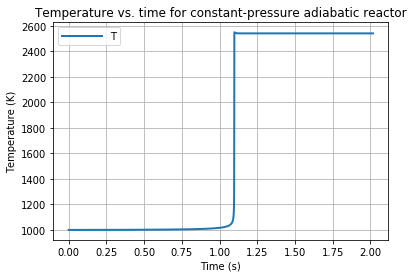

In [34]:
# plot the time evolution of temperature
fig, ax = plt.subplots()
ax.plot(timeHistory.index, timeHistory['temperature'], label='T', lw=2)
ax.set(xlabel='Time (s)',
       ylabel='Temperature (K)',
       title ='Temperature vs. time for constant-pressure adiabatic reactor')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("T_vs_t_pconst.pdf")

The behavior is qualitatively similar to what we saw earlier for a constant-volume reactor.

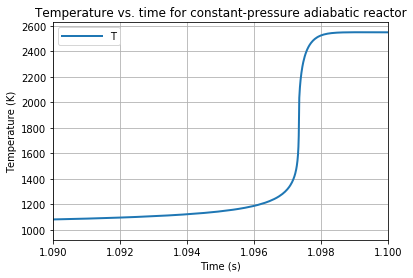

In [35]:
# zoom in around the "ignition time"
fig, ax = plt.subplots()
ax.plot(timeHistory.index, timeHistory['temperature'], label='T', lw=2)
ax.set(xlim=(1.09,1.10),
       xlabel='Time (s)',
       ylabel='Temperature (K)',
       title ='Temperature vs. time for constant-pressure adiabatic reactor')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("T_vs_t_pconst_zoom.pdf")

The system "ignites" (characterized by the very rapid time-rate-of-change of temperature) at approximately 1.0973 s (see the Excel-compatible file that was written earlier).

### 2.5 Examine the chemical time scales

The comments at the end of Example 4.5 of Turns 4th ed. address the significance of the wide range of chemical time scales in combustion, for reactions r1-r4 at two instants in time. Here we build on that by examining the chemical time scales for those reactions over a wider range of conditions, and for two additional reactions.

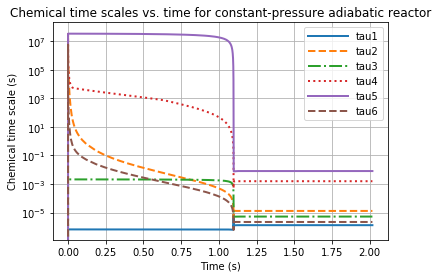

In [36]:
# plot the time evolution of the chemical time scales
# use a logarithmic scale for the time scales, which vary over several orders of magnitude
fig, ax = plt.subplots()
ax.semilogy(timeHistory.index, timeHistory['tau1'], label='tau1', ls='solid',   lw=2)
ax.semilogy(timeHistory.index, timeHistory['tau2'], label='tau2', ls='dashed',  lw=2)
ax.semilogy(timeHistory.index, timeHistory['tau3'], label='tau3', ls='dashdot', lw=2)
ax.semilogy(timeHistory.index, timeHistory['tau4'], label='tau4', ls='dotted',  lw=2)
ax.semilogy(timeHistory.index, timeHistory['tau5'], label='tau5', ls='solid',   lw=2)
ax.semilogy(timeHistory.index, timeHistory['tau6'], label='tau6', ls='dashed',  lw=2)
ax.set(xlabel='Time (s)',
       ylabel='Chemical time scale (s)',
       title ='Chemical time scales vs. time for constant-pressure adiabatic reactor')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("tau_vs_t_pconst.pdf")

The time scales vary over a range of greater than 13 orders of magnitude.

Prior to ignition, the shortest time scale is for reaction r1 (hydroxyl radical attacking methane), and the longest is for reaction r5 (rate-limiting step in thermal NO formation). The three-body reaction r4 is slower than any of the two-body reactions, with the exception of the NO reaction. The CO to CO2 reaction (r2) is also slow initially. All of the time scales decrease as the system progresses toward "ignition". The time scale for the shuffle reaction (r6), in particular, decreases significantly, and actually becomes the fastest reaction of the six considered here for a brief time during the main ignition even, when the radical pool is most active. This can be seen by zooming in: 

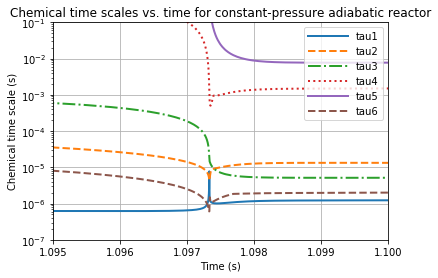

In [37]:
# plot the time evolution of the chemical time scales
# use a logarithmic scale for the time scales, which vary over several orders of magnitude
fig, ax = plt.subplots()
ax.semilogy(timeHistory.index, timeHistory['tau1'], label='tau1', ls='solid',   lw=2)
ax.semilogy(timeHistory.index, timeHistory['tau2'], label='tau2', ls='dashed',  lw=2)
ax.semilogy(timeHistory.index, timeHistory['tau3'], label='tau3', ls='dashdot', lw=2)
ax.semilogy(timeHistory.index, timeHistory['tau4'], label='tau4', ls='dotted',  lw=2)
ax.semilogy(timeHistory.index, timeHistory['tau5'], label='tau5', ls='solid',   lw=2)
ax.semilogy(timeHistory.index, timeHistory['tau6'], label='tau6', ls='dashed',  lw=2)
ax.set(xlim=(1.095,1.10),
       ylim=(1.e-07,1.e-01),
       xlabel='Time (s)',
       ylabel='Chemical time scale (s)',
       title ='Chemical time scales vs. time for constant-pressure adiabatic reactor')
ax.legend(handlelength=4,loc='best')
ax.grid(True)
fig.savefig("tau_vs_t_pconst_zoom.pdf")

The combination of the relatively long time scales associated with three-body recombination reactions (reaction r4) and the short time scales associated with radical shuffle reactions (reaction r6) allows simplifications such as partial equilibrium to be invoked.

Note that even after the main ignition event has been completed, thermal NO formation (reaction r5) remains slow compared to all other reactions considered here.

## 3. What's next

Chemical time scale analysis can be used to simplify reaction mechanisms: for example, to determine for which species a steady-state approximation should be appropriate, and/or for which reactions a partial-equilbrium approximation should be appropriate. As we will see later, it will also be useful to compare chemical time scales with time scales for other physical processes in combustion, such as molecular and turbulent transport.

Finally, it is noted that several alternative heuristic and formal definitions of chemical time scales have been proposed. The interested reader can search on "chemical time scales" and similar combinations of key words for additional information.